In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 수집한 데이터

In [2]:
data = pd.read_excel('./data/samsung.xlsx')
data

,DATE,거래량,PER,PBR,기관 합계,기타법인,개인,외국인 합계,ATR,NASDAQ,S&P,CBOE,Exchange rate,futures2y,futures10y,y
0,2011-09-01,35870550,7.27,1.24,-83833734000,-8749641000,-177822918000,270406293000,880,"2,546.00","1,204.42",31.82,"1,064.40",110.28,130.61,15420
1,2011-09-02,12934100,7.26,1.23,-7185878000,2125969000,-11377060000,16436969000,1000,"2,480.30","1,173.97",33.92,"1,065.60",110.25,131.30,15380
2,2011-09-05,13874400,6.90,1.17,-975699000,-215641000,29370756000,-28179416000,580,"2,480.30","1,173.97",33.92,"1,065.60",110.25,131.30,14620
3,2011-09-06,13225250,6.86,1.17,2349662000,-1299409000,13839817000,-14890070000,1260,"2,473.80","1,165.24",37.00,"1,074.65",110.27,131.22,14540
4,2011-09-07,17575200,7.29,1.24,113232351000,1123519000,-77907268000,-36448602000,1300,"2,548.90","1,198.62",33.38,"1,069.65",110.27,130.89,15460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,2021-08-25,22319664,19.71,1.92,-76990474100,-8894667500,82373232300,3511909300,2000,"15,041.90","4,496.19",16.79,"1,163.87",110.25,133.63,75700
2457,2021-08-26,16671494,19.42,1.89,-55566537800,9344981600,142574757300,-96353201100,1900,"14,945.80","4,469.91",18.84,"1,170.53",110.25,133.59,74600
2458,2021-08-27,15172748,19.34,1.89,173118394100,10372274300,1510887500,-185001555900,1200,"15,129.50","4,509.37",16.39,"1,161.23",110.30,133.89,74300
2459,2021-08-30,12686999,19.42,1.89,24586418600,-2401179400,54715193800,-76900433000,2500,"15,265.90","4,528.79",16.19,"1,164.34",110.32,134.13,74600


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           2461 non-null   datetime64[ns]
 1   거래량            2461 non-null   int64         
 2   PER            2461 non-null   float64       
 3   PBR            2461 non-null   float64       
 4   기관 합계          2461 non-null   int64         
 5   기타법인           2461 non-null   int64         
 6   개인             2461 non-null   int64         
 7   외국인 합계         2461 non-null   int64         
 8   ATR            2461 non-null   int64         
 9   NASDAQ         2461 non-null   object        
 10  S&P            2461 non-null   object        
 11  CBOE           2461 non-null   float64       
 12  Exchange rate  2461 non-null   object        
 13  futures2y      2461 non-null   float64       
 14  futures10y     2461 non-null   float64       
 15  y              2461 n

In [4]:
# 실수형으로 변환

data['CBOE'] = data['CBOE'].astype('float')
data['futures2y'] = data['futures2y'].astype('float')
data['futures10y'] = data['futures10y'].astype('float')

In [5]:
# 실수형으로 변환(값에 ','가 포함된 경우)

data['NASDAQ'] = data['NASDAQ'].str.replace(',', '').astype(float)
data['S&P'] = data['S&P'].str.replace(',', '').astype(float)
data['Exchange rate'] = data['Exchange rate'].str.replace(',', '').astype(float)

In [6]:
scaler = MinMaxScaler()

In [7]:
scale_cols = ['거래량', 'PER', 'PBR', '기관 합계', '기타법인', '개인', '외국인 합계', 'ATR', 'NASDAQ', 'S&P', 'CBOE', 'Exchange rate', 'futures2y', 'futures10y', 'y']

In [8]:
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[0.37435295, 0.07735281, 0.07361963, ..., 0.95700935, 0.57105031,
        0.01150929],
       [0.11073659, 0.07692308, 0.06748466, ..., 0.95140187, 0.60150044,
        0.01098614],
       [0.12154377, 0.06145251, 0.03067485, ..., 0.95140187, 0.60150044,
        0.0010463 ],
       ...,
       [0.13646612, 0.59604641, 0.47239264, ..., 0.96074766, 0.71579876,
        0.78158514],
       [0.10789657, 0.59948431, 0.47239264, ..., 0.96448598, 0.72639011,
        0.78550876],
       [0.24516577, 0.6231199 , 0.50920245, ..., 0.96448598, 0.72285966,
        0.8129741 ]])

In [9]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('y', 1), df['y'], test_size=0.2, random_state=0, shuffle=False)

In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1968, 14), (1968,), (493, 14), (493,))

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [95]:
WINDOW_SIZE=120
BATCH_SIZE=32

In [96]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [97]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 120, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [98]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [99]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [141]:
earlystopping = EarlyStopping(monitor='val_loss', patience=100, mode='min')
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [142]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=1000, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/1000
58/58 [==============================] - 3s 46ms/step - loss: 2.8909e-05 - mse: 5.7818e-05 - val_loss: 3.2234e-04 - val_mse: 6.4468e-04

Epoch 00001: val_loss improved from inf to 0.00032, saving model to tmp\ckeckpointer.ckpt
Epoch 2/1000
58/58 [==============================] - 3s 51ms/step - loss: 2.9677e-05 - mse: 5.9355e-05 - val_loss: 3.2870e-04 - val_mse: 6.5741e-04

Epoch 00002: val_loss did not improve from 0.00032
Epoch 3/1000
58/58 [==============================] - 3s 41ms/step - loss: 2.7424e-05 - mse: 5.4848e-05 - val_loss: 3.5950e-04 - val_mse: 7.1900e-04

Epoch 00003: val_loss did not improve from 0.00032
Epoch 4/1000
58/58 [==============================] - 3s 40ms/step - loss: 2.8168e-05 - mse: 5.6336e-05 - val_loss: 4.4872e-04 - val_mse: 8.9745e-04

Epoch 00004: val_loss did not improve from 0.00032
Epoch 5/1000
58/58 [==============================] - 3s 41ms/step - loss: 2.9939e-05 - mse: 5.9877e-05 - val_loss: 3.2375e-04 - val_mse: 6.4750e-04

Epoch 0

58/58 [==============================] - 3s 45ms/step - loss: 2.8357e-05 - mse: 5.6713e-05 - val_loss: 4.7776e-04 - val_mse: 9.5551e-04

Epoch 00041: val_loss did not improve from 0.00029
Epoch 42/1000
58/58 [==============================] - 3s 43ms/step - loss: 2.7859e-05 - mse: 5.5717e-05 - val_loss: 5.8573e-04 - val_mse: 0.0012

Epoch 00042: val_loss did not improve from 0.00029
Epoch 43/1000
58/58 [==============================] - 3s 45ms/step - loss: 2.8384e-05 - mse: 5.6768e-05 - val_loss: 4.6431e-04 - val_mse: 9.2862e-04

Epoch 00043: val_loss did not improve from 0.00029
Epoch 44/1000
58/58 [==============================] - 3s 48ms/step - loss: 2.9286e-05 - mse: 5.8572e-05 - val_loss: 4.8346e-04 - val_mse: 9.6692e-04

Epoch 00044: val_loss did not improve from 0.00029
Epoch 45/1000
58/58 [==============================] - 3s 47ms/step - loss: 2.8968e-05 - mse: 5.7935e-05 - val_loss: 5.3713e-04 - val_mse: 0.0011

Epoch 00045: val_loss did not improve from 0.00029
Epoch 46/100

58/58 [==============================] - 3s 46ms/step - loss: 2.7740e-05 - mse: 5.5479e-05 - val_loss: 3.0667e-04 - val_mse: 6.1334e-04

Epoch 00081: val_loss did not improve from 0.00026
Epoch 82/1000
58/58 [==============================] - 3s 46ms/step - loss: 2.8970e-05 - mse: 5.7940e-05 - val_loss: 4.8922e-04 - val_mse: 9.7844e-04

Epoch 00082: val_loss did not improve from 0.00026
Epoch 83/1000
58/58 [==============================] - 3s 44ms/step - loss: 2.8476e-05 - mse: 5.6952e-05 - val_loss: 3.5398e-04 - val_mse: 7.0796e-04

Epoch 00083: val_loss did not improve from 0.00026
Epoch 84/1000
58/58 [==============================] - 3s 53ms/step - loss: 2.8793e-05 - mse: 5.7585e-05 - val_loss: 4.5345e-04 - val_mse: 9.0691e-04

Epoch 00084: val_loss did not improve from 0.00026
Epoch 85/1000
58/58 [==============================] - 3s 54ms/step - loss: 2.8446e-05 - mse: 5.6892e-05 - val_loss: 3.7613e-04 - val_mse: 7.5225e-04

Epoch 00085: val_loss did not improve from 0.00026
Epoc

58/58 [==============================] - 3s 47ms/step - loss: 2.8217e-05 - mse: 5.6435e-05 - val_loss: 2.1696e-04 - val_mse: 4.3392e-04

Epoch 00121: val_loss did not improve from 0.00014
Epoch 122/1000
58/58 [==============================] - 3s 44ms/step - loss: 2.8263e-05 - mse: 5.6527e-05 - val_loss: 3.2735e-04 - val_mse: 6.5469e-04

Epoch 00122: val_loss did not improve from 0.00014
Epoch 123/1000
58/58 [==============================] - 3s 48ms/step - loss: 2.9011e-05 - mse: 5.8023e-05 - val_loss: 2.3653e-04 - val_mse: 4.7306e-04

Epoch 00123: val_loss did not improve from 0.00014
Epoch 124/1000
58/58 [==============================] - 3s 50ms/step - loss: 2.9625e-05 - mse: 5.9249e-05 - val_loss: 1.8581e-04 - val_mse: 3.7162e-04

Epoch 00124: val_loss did not improve from 0.00014
Epoch 125/1000
58/58 [==============================] - 3s 44ms/step - loss: 2.8605e-05 - mse: 5.7210e-05 - val_loss: 2.8747e-04 - val_mse: 5.7495e-04

Epoch 00125: val_loss did not improve from 0.00014


58/58 [==============================] - 4s 57ms/step - loss: 2.8074e-05 - mse: 5.6148e-05 - val_loss: 2.3630e-04 - val_mse: 4.7260e-04

Epoch 00161: val_loss did not improve from 0.00014
Epoch 162/1000
58/58 [==============================] - 3s 52ms/step - loss: 2.8817e-05 - mse: 5.7635e-05 - val_loss: 2.4366e-04 - val_mse: 4.8733e-04

Epoch 00162: val_loss did not improve from 0.00014
Epoch 163/1000
58/58 [==============================] - 3s 52ms/step - loss: 2.9495e-05 - mse: 5.8991e-05 - val_loss: 2.6449e-04 - val_mse: 5.2899e-04

Epoch 00163: val_loss did not improve from 0.00014
Epoch 164/1000
58/58 [==============================] - 3s 49ms/step - loss: 3.0208e-05 - mse: 6.0417e-05 - val_loss: 2.4819e-04 - val_mse: 4.9637e-04

Epoch 00164: val_loss did not improve from 0.00014
Epoch 165/1000
58/58 [==============================] - 3s 49ms/step - loss: 2.8107e-05 - mse: 5.6214e-05 - val_loss: 3.8922e-04 - val_mse: 7.7843e-04

Epoch 00165: val_loss did not improve from 0.00014


In [143]:
model.load_weights(filename)

In [144]:
pred = model.predict(test_data)

In [145]:
pred.shape

(373, 1)

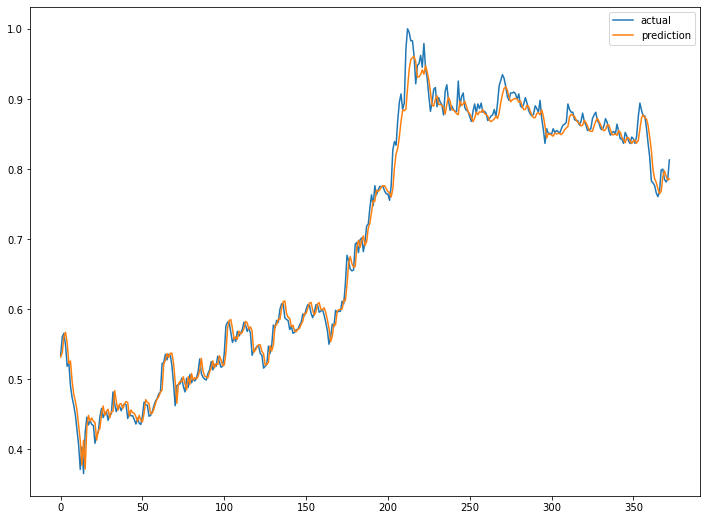

In [146]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[120:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [147]:
def RMSE(y_test, pred):
    return np.sqrt(mean_squared_error(y_test[120:], pred))

print('RMSE : ', RMSE(y_test, pred)) 

RMSE :  0.016966030261474068


In [148]:
r2_y_predict = r2_score(y_test[120:], pred)

print('R2 : ', r2_y_predict)

R2 :  0.9910964146785091


In [ ]:
val_lose 0.00013
RMSE : 0.01586393814653742
R2 : 0.9922155763036076